# Training

## Settings and Imports

In [1]:
#Basic Imports
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import shutil

#PyTorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
#Additional layers for KeypointRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNHeads
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor

In [2]:
#Own Code
from configs import training_configs, model_configs
from scripts import create_yolo_annotations
from dataset import dataset,dataset_transforms
from model_arch import keypoint_model

In [3]:
#Settings

%matplotlib inline

#autoreload other packages when code changed
%load_ext autoreload
%autoreload 2

# Print out every value 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display,clear_output

# suppress warnings
#import warnings
#warnings.filterwarnings('ignore')

In [4]:
#move model to cuda if available 
if torch.cuda.is_available():
    print("GPU will be used")
    device = torch.device('cuda') 
else:
    print("No GPU available")
    device = torch.device('cpu')

GPU will be used


Training KeypointRCNN and FasterRCNN from PyTorch uses some helper scripts from the torchvision git repo. They aren't included in the module itself, so we need to copy them out of the git repo

In [5]:
%%capture
!git clone https://github.com/pytorch/vision.git
shutil.copy('vision/references/detection/utils.py','./')
shutil.copy('vision/references/detection/transforms.py','./')
shutil.copy('vision/references/detection/coco_eval.py','./')
shutil.copy('vision/references/detection/engine.py','./')
shutil.copy('vision/references/detection/coco_utils.py','./')
from engine import train_one_epoch, evaluate

## YOLOv5

YOLOv5 has an [implementation](https://github.com/ultralytics/yolov5) in PyTorch. It already has different scripts for training and testing, which we will make use of.  
It commands should be executed inside the Terminal, but can also be executed from this notebook

The data needs to be in a specific format, which will be created via `scripts/create_yolo_annotations.py`. This will copy all the images (from the standard InterHand2.6M file structure) into a single folder and create the annotations in a seperate *.txt file for each image.   
NOTE: The training set has ~1.4M Images. Windows can not handle so many files in a single folder that efficient. Copying took ~40h. (Val dataset with ~400K Images only took 30mins)

In [6]:
#create Yolo dataset
#The better way would be to call the script directly in the Terminal.

#create_yolo_annotations.copy_images_and_create_annotations(mode='train')
#create_yolo_annotations.copy_images_and_create_annotations(mode='test')
#create_yolo_annotations.copy_images_and_create_annotations(mode='val')

In [7]:
#clone the YOLOv5 Repo
# !git clone https://github.com/ultralytics/yolov5
#the requirements are already in the requirements of this project, thus we dont need to install anything additional

In [8]:
#Train YOLO model 
# !python .\yolov5\train.py --batch 2 --epochs 2 --data yolo_data/yolo_dataset.yaml --weights yolov5s.pt --freeze 8

## KeypointRCNN und FasterRCNN

### Dataset and Dataloader

The dataset is defined inside `dataset/dataset.py` script

In [15]:
train_data= dataset.Dataset(mode='train',only_keypoints = False, limit_handedness='all')
val_data  = dataset.Dataset(mode='val',  only_keypoints = False, limit_handedness='all')
#test_data = dataset.Dataset(mode='test',only_keypoints = False, limit_handedness='all')

loading annotations into memory...
Done (t=49.05s)
creating index...
index created!
loading annotations into memory...
Done (t=11.29s)
creating index...
index created!


We define our own collate function, because otherwise the dict from the dataset would merge together. We want to avoid this

In [16]:
def collate_func(batch):
    return tuple(zip(*batch))

train_dataloader= DataLoader(train_data,batch_size = training_configs.BATCH_SIZE, shuffle = True, collate_fn=collate_func)
val_dataloader  = DataLoader(val_data,  batch_size = training_configs.BATCH_SIZE, shuffle = False, collate_fn=collate_func)
#test_dataloader = DataLoader(test_data, batch_size = training_configs.BATCH_SIZE, shuffle = False, collate_fn=collate_func)

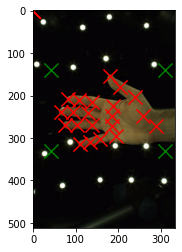

In [18]:
#Print example image

data = val_data[0]
img = data[0]

plt.imshow(img.permute(1, 2, 0))

#Plot keypoints
keypoints = data[1]['keypoints'][0]
plt.scatter(keypoints[:, 0], keypoints[:, 1], marker="x", color="red", s=200)

#plot bbox corners
bbox = data[1]['boxes'][0]
bbox = np.array([ [bbox[0],bbox[1]], [bbox[0],bbox[3]] , [bbox[2],bbox[1]] ,[bbox[2], bbox[3]] ])
plt.scatter(bbox[:, 0], bbox[:, 1], marker="x", color="green", s=200)

### KeypointRCNN Model

There is already a FasterRCNN and a KeypointRCNN implementation in PyTorch. 

In [ ]:
#load pretrained KeypointRCNN model
model_keyRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=2)

The PyTorch FasterRCNN model is pre trained on the COCO dataset, which contains 80 classes. We have much less classes, thus we need to swap the classifier to just predict the handedness

In [ ]:
num_classes = 4 #right, left, interacting hands and background

# get number of input features (from the backbone)
in_features = model_keyRCNN.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one()
model_keyRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Also it is pretrained on human poses, thus we also need to change amount of keypoints

In [ ]:
#number of outputs_channels of backbone is needed as the number of input channels in the keypointHead
num_out_channels = model_keyRCNN.backbone.out_channels
keypoint_layers = tuple(512 for _ in range(8)) #num of layers
model_keyRCNN.roi_heads.keypoint_head = KeypointRCNNHeads(num_out_channels, keypoint_layers)

num_keypoints = 42 #21 per hand
keypoint_dim_reduced = 512
model_keyRCNN.roi_heads.keypoint_predictor = KeypointRCNNPredictor(keypoint_dim_reduced,num_keypoints)

The model uses a pretrained resnet backbone, which we won't train. Thus we need to freeze the layers

In [ ]:
#Already done in the constructor

#for layer_name,layer_tensor in model.named_parameters():
#    if layer_name.startswith('backbone.body.'):
#        layer_tensor.requires_grad=False

### FasterRCNN Model

For the FasterRCNN Model we also load the pretrained model from PyTorch and 

In [ ]:
model_fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=2)
num_classes = 4 #right, left, interacting hands and background

# get number of input features (from the backbone)
in_features = model_fasterRCNN.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model_fasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Training

Both models can be trained in the same way, using the same dataloaders. Thus change them if needed

In [ ]:
#Select Model to Train 
model_to_train = 'FasterRCNN' # or 'KeypointRCNN'

if model_to_train == 'FasterRCNN':
    model = model_fasterRCNN
    model_name = 'faster_rcnn_model.pt'
else:
    model = model_keyRCNN
    model_name = 'keypoint_rcnn_model.pt'

model.to(device)

In [ ]:
InteractiveShell.ast_node_interactivity = "none"

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate scheduler, decreaing learning rate 10x every epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.1)


for epoch in range(training_configs.EPOCHS):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    # evaluate on the val dataset
    #evaluate(model, val_dataloader, device=device)
    # update the learning rate
    lr_scheduler.step()

In [ ]:
torch.save(model.state_dict(), f'{model_to_train}_model.pt')

## Keypoint Layer

If we use Faster RCNN for Object Detection, we need to train a seperate keypoint detection head.

The handedness (left, right or interacting) is predicted inside the FasterRCNN Model, thus we don't need to train a seperate classifier

### Datasets and Dataloader

The images should be cropped so that the hands are in the center of the image.  
Also the keypoints should be normalized. This preprocessing is already implemented in the Dataset-Class

In [5]:
transform = transforms.Compose([transforms.Resize(model_configs.INPUT_IMG_SHAPE) ,transforms.ToTensor()])

train_interacting_data = dataset.Dataset(mode='train',transform=transform, only_keypoints = True, limit_handedness='interacting')
train_single_data      = dataset.Dataset(mode='train',transform=transform, only_keypoints = True, limit_handedness='single')
#train_left_data       = dataset.Dataset(mode='train',transform=transform, only_keypoints = True, limit_handedness='left')
#train_right_data      = dataset.Dataset(mode='train',transform=transform, only_keypoints = True, limit_handedness='right')

val_interacting_data   = dataset.Dataset(mode='val',transform = transform, only_keypoints = True, limit_handedness='interacting')
val_single_data        = dataset.Dataset(mode='val',transform = transform, only_keypoints = True, limit_handedness='single')
#val_left_data         = dataset.Dataset(mode='val',transform = transform, only_keypoints = True, limit_handedness='left')
#val_right_data        = dataset.Dataset(mode='val',transform = transform, only_keypoints = True, limit_handedness='right')

loading annotations into memory...
Done (t=77.85s)
creating index...
index created!
loading annotations into memory...
Done (t=50.58s)
creating index...
index created!
loading annotations into memory...
Done (t=16.31s)
creating index...
index created!
loading annotations into memory...
Done (t=15.90s)
creating index...
index created!


In [6]:
train_interacting_dataloader = DataLoader(train_interacting_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
train_single_dataloader      = DataLoader(train_single_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
#train_left_dataloader        = DataLoader(train_left_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
#train_right_dataloader       = DataLoader(train_right_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)

val_interacting_dataloader = DataLoader(val_interacting_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
val_single_dataloader      = DataLoader(val_single_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
#val_left_dataloader        = DataLoader(val_left_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)
#val_right_dataloader       = DataLoader(val_right_data, batch_size = training_configs.BATCH_SIZE, shuffle = True)

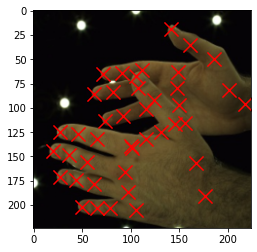

In [7]:
#Print example image
data = val_interacting_data[0]
img = data[0]
kps = data[1]

#plot image
plt.imshow( img.permute(1, 2, 0))

#Plot keypoints
new_kps = torch.clone(kps)
new_kps = torch.reshape(new_kps,(-1,2))
new_kps[:,0] = new_kps[:,0] * img.shape[1]
new_kps[:,1] = new_kps[:,1] * img.shape[2]
plt.scatter(new_kps[:, 0], new_kps[:, 1], marker="x", color="red", s=200)

### Models

We create a seperate model for single hand and for interacting hands.

The model uses a pretrained VGG16 backbone, with some additional dense layers in the end. The number of outputs is equal to 2*num_keypoints (x,y coord for each keypoint)

In [8]:
interacting_model = keypoint_model.get_keypoint_model(num_keypoints= 42).to(device)
single_model = keypoint_model.get_keypoint_model(num_keypoints= 21).to(device)

### Training

We need some helper methods for training

In [9]:
def train_batch(img, kps, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    #forward pass
    _kps = model(img.to(device))
    #calculate loss
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    #update weights
    optimizer.step()
    return loss

@torch.no_grad()
def validate_batch(img, kps, model, criterion):
    model.eval()
    #forward pass
    _kps = model(img.to(device))
    #calculate loss
    loss = criterion(_kps, kps.to(device))
    return loss


def train_model(model, train_dataloader, val_dataloader, save_name):
    train_loss = []
    val_loss = []

    optimizer = torch.optim.Adam(model.parameters(), lr = training_configs.LEARNING_RATE)
    criterion = nn.MSELoss()

    for epoch in range(training_configs.EPOCHS):
        epoch_train_loss, epoch_val_loss = 0,0
        for ix, (img,kps) in enumerate(train_dataloader):
            #log current progress
            if ix % 1000 == 0:
                #instead of print, we use the IPython display method
                #this has the effect, that only the last display() call is shown in the output
                #this makes the output of this cell way smaller 
                clear_output(wait=True)
                current_loss = epoch_train_loss/ix if ix != 0 else 0
                display(f'Epoch {epoch+1} : {training_configs.EPOCHS}, Batch {ix} : {len(train_dataloader)} of training, Current avg loss: {current_loss}')
            #train batch and save loss
            loss = train_batch(img,kps,model,optimizer, criterion)
            epoch_train_loss += loss.item()
        #calculate avg loss of this epoch
        epoch_train_loss /= (ix + 1)
        train_loss.append(epoch_train_loss)

        for ix, (img,kps) in enumerate(val_dataloader):
            #log current progress
            if ix % 1000 == 0:
                clear_output(wait=True)
                current_loss = epoch_val_loss/ix if ix != 0 else 0
                display(f'Epoch {epoch+1} : {training_configs.EPOCHS}, Batch {ix} : {len(val_dataloader)} of validation, Current avg loss: {current_loss}')
            loss = validate_batch(img, kps, model, criterion)
            epoch_val_loss = loss.item()
        #calculate avg validation loss of this epoch
        epoch_val_loss /= (ix + 1)
        val_loss.append(epoch_val_loss)
    #save model
    torch.save(model.state_dict(), f'{save_name}_model.pt')
    print(f'Train loss: {train_loss}, Val loss: {val_loss}')

In [11]:
#Train single hand model
train_model(model = single_model, 
            train_dataloader= train_single_dataloader,
            val_dataloader= val_single_dataloader,
            save_name="keypoint_single")

'Epoch 5 : 5, Batch 117000 : 117092 of validation, Current avg loss: 1.7917568548622294e-07'

Train loss: [0.012425927423141341, 0.009306722007188272, 0.008526695021826007, 0.008079812213663716, 0.007810688102841125], Val loss: [1.5292705296278935e-08, 6.281840440786985e-08, 8.22024125105307e-08, 6.943020451807192e-08, 1.9487139836950924e-07]


In [10]:
#train interacting model 
train_model(model = interacting_model, 
            train_dataloader= train_interacting_dataloader,
            val_dataloader= val_interacting_dataloader,
            save_name="keypoint_interacting")

'Epoch 5 : 5, Batch 72000 : 72971 of validation, Current avg loss: 9.896806958648894e-07'

Train loss: [0.036808625663583325, 0.028685701544866396, 0.02585684172884662, 0.024045836075995548, 0.022743157467406988], Val loss: [1.0149316053490743e-06, 6.72599118768526e-07, 9.4043907281007e-07, 2.247916672101721e-06, 1.134129357225883e-06]
